In [ ]:
!pip install torch_geometric

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
from helpers_functions import *
from gymnasium import spaces
from gerry_environment import FrankenmanderingEnv
from graph_initiator import build_init_data
from mcmc_commit import mcmc_full_annealing
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
init_data, G_graph = build_init_data()
print(init_data)

BA (undirected) edges: 140 (expected m*(N-m) = 2*(72-2) = 140)
SOC directed arcs: 280 (should be 2 * 140 = 280)
FrankenData(x=[72, 1], edge_index=[2, 280], edge_attr=[280], y=[72], pos=[72, 2])


In [ ]:
g = init_data.get_geo_edge()
g

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19,
         20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39,
         40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59,
         60, 61, 63, 64, 65, 66, 67, 68, 69, 70,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
         44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
         62],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20,
         21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40,
         41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60,
         61, 62, 64, 65, 66, 67, 68, 69, 70, 71,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 3

In [ ]:
d = init_data.get_y()
d

tensor([5, 3, 3, 3, 3, 3, 2, 2, 2, 5, 3, 3, 3, 1, 1, 2, 2, 2, 5, 3, 3, 3, 1, 1,
        1, 2, 2, 5, 3, 3, 3, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 2, 2, 3, 3, 4,
        1, 1, 1, 0, 2, 2, 4, 3, 4, 4, 4, 4, 0, 0, 2, 4, 4, 4, 4, 4, 0, 0, 0, 0])

In [ ]:
# |# hot_steps = 500
# # anneal_steps =10
# #  cold_steps = 100
# # beta1 = 0.005# beta2 = 0.01

# # Ican consider outer loop = 100,
# # T_init = 1,
# # T_final = 0.01,
# # p_keep = 0.5


In [ ]:
num_voters = init_data.get_x().shape[0]
num_districts = 6
target_opinion = [7] * num_voters

env_sco = FrankenmanderingEnv(num_voters=num_voters,
                          num_districts=num_districts,
                          opinion_dim=1,
                          init_FrankenData=init_data,
                          target_opinion=target_opinion)

initial_opinion = init_data.get_x()

summary_full = []

for i in range(10):
  env_sco.reset()
  df_summary, best_sample = mcmc_full_annealing(
      env =env_sco ,
      outer_loops = 100,
      hot_steps = 100,
      anneal_steps =80,
      cold_steps = 20,
      T_init = 1,
      T_final = 0.01,
      seed = 42,
      drf = drf_inchworm_withso,
      beta1 = 0.1,
      beta2 = 0.5,
      p_keep = 0.5,
      num_districts = num_districts
  )
  print('step=',i)
  summary_full.append(best_sample)

df_full = pd.DataFrame(summary_full)

step= 0
step= 1
step= 2
step= 3
step= 4
step= 5
step= 6
step= 7
step= 8
step= 9


In [ ]:
# type(init_data.get_x())

In [ ]:
df_summary.to_csv('output_stage.csv', index=False)
df_full.to_csv('output_full.csv', index = False)

# **Report of MCMC stage**

**Opinion distribution across 100 outer steps**





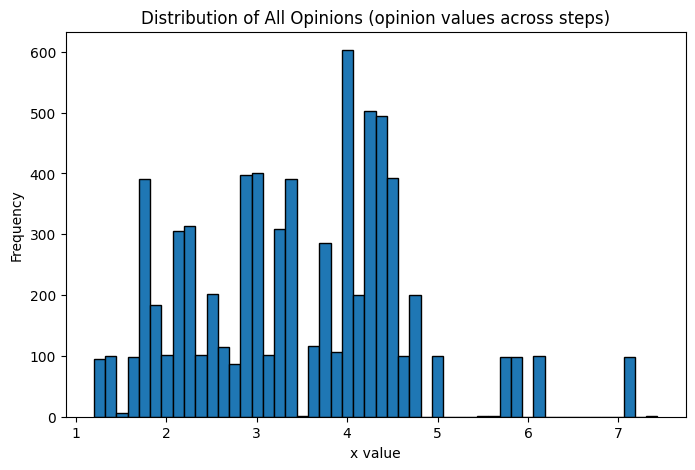

In [ ]:
def opinion_distribution(df,all_x):
  # best_model = df['best_model_stage']
  all_opinion = []

  # for row in best_model:
  #   all_opinion.append(row.get_x())

  all_opinion_tensor = torch.cat(all_x)
  all_opinion_np = all_opinion_tensor.cpu().numpy()

  return all_opinion_np, all_opinion

# plot
# best_model = df_summary['best_model_stage']
all_x = [data.x for data in df_summary['best_model_stage']]
all_opinion_np, all_opinion = opinion_distribution(df_summary, all_x)

plt.figure(figsize=(8,5))
plt.hist(all_opinion_np, bins=50, edgecolor='black')
plt.title("Distribution of All Opinions (opinion values across steps)")
plt.xlabel("x value")
plt.ylabel("Frequency")
plt.show()

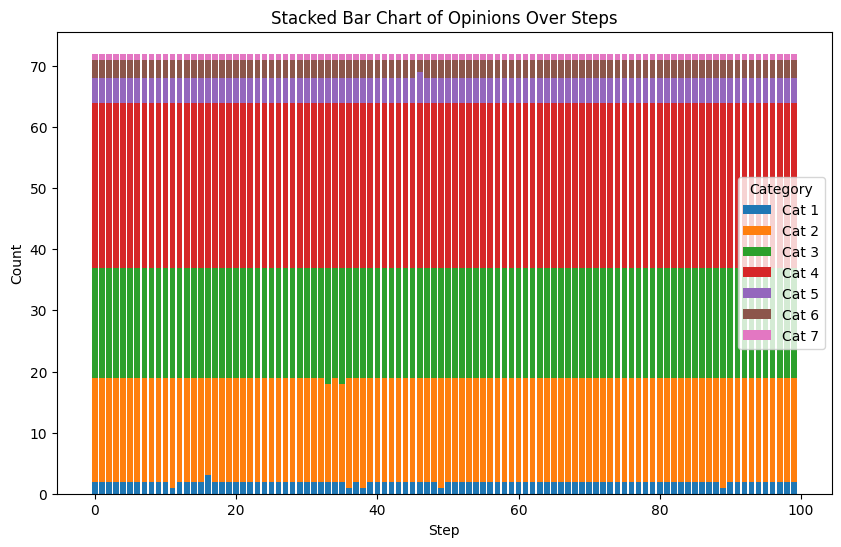

Category 1: 196.0 occurrences
Category 2: 1702.0 occurrences
Category 3: 1802.0 occurrences
Category 4: 2700.0 occurrences
Category 5: 401.0 occurrences
Category 6: 299.0 occurrences
Category 7: 100.0 occurrences


In [ ]:
def opnion_freq(all_opinion,num_steps):
  # frequency of different opinions in each outer step. For example, how many voters have opinion 3 in each step

  all_opinion_np = [op.cpu().numpy() if isinstance(op, torch.Tensor) else np.array(op) for op in all_opinion]
  all_opinion_np = np.round(all_opinion_np)

  # num_steps = len(all_opinion_np)
  categories, _ = np.unique(all_opinion_np, return_counts=True)

  counts = np.zeros((num_steps,len(categories)))

  for i, opinions in enumerate(all_opinion_np):
      for j, cat in enumerate(categories):
        counts[i, j] = np.sum(opinions == cat)

  return  categories, counts

# Plot
num_steps = len(all_x)
categories, counts = opnion_freq(all_x,num_steps)
x = np.arange(num_steps)
bottom = np.zeros(num_steps)

plt.figure(figsize=(10, 6))

for j, cat in enumerate(categories):
    plt.bar(x, counts[:, j], bottom=bottom, label=f'Cat {int(cat)}')
    bottom += counts[:, j]

plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Opinions Over Steps')
plt.legend(title='Category')
plt.show()

# Overall frequency of each category across all steps
total_frequency = counts.sum(axis=0)
for cat, freq in zip(categories, total_frequency):
    print(f'Category {int(cat)}: {freq} occurrences')


**Reward Trajectory**

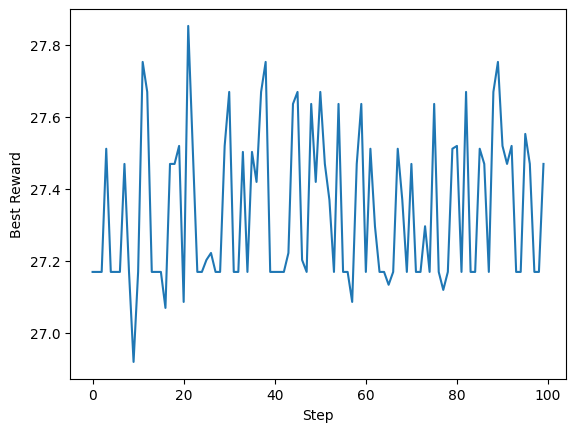

In [ ]:
import matplotlib.pyplot as plt

x = df_summary['best_reward_stage']
plt.plot(range(len(x)), x)  # x-axis: step/index, y-axis: reward
plt.xlabel("Step")
plt.ylabel("Best Reward")
plt.show()


In [ ]:
def mean_change_op(df, init_data):
    """
    Calculate the mean and std of the Euclidean distance between each opinion component and initial opinion
    at each step.
    """
    mean_change = []
    std_step = []

    # convert init_data to tensor if needed
    if not isinstance(init_data, torch.Tensor):
        init_data = torch.tensor(init_data, dtype=torch.float32)

    best_model = df['best_model_stage']

    for row in best_model:
        x = row.get_x()  # should return tensor of shape [N_features]
        # distance per component
        diff = x - init_data
        # L2 distance for each element
        # if you want distance per feature:
        distances = torch.abs(diff)  # element-wise distance
        mean_change.append(torch.mean(distances).item())
        std_step.append(torch.std(distances).item())

    return mean_change, std_step


# This plot illustrates the mean and std of opinion distance from initital opinion

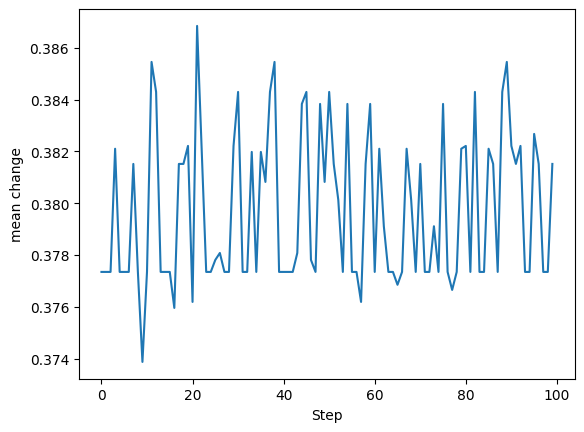

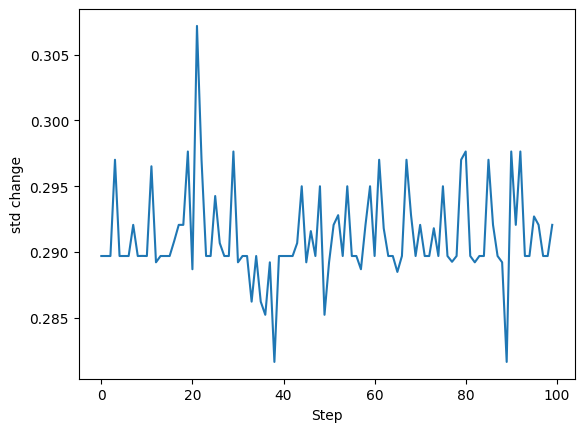

In [ ]:
res_mean, res_std = mean_change_op(df_summary, initial_opinion)

# line plot
plt.plot(range(len(res_mean)), res_mean)
plt.xlabel("Step")
plt.ylabel("mean change")
plt.show()

plt.plot(range(len(res_std)), res_std)
plt.xlabel("Step")
plt.ylabel("std change")

plt.show()

# **Report of outer anealing**

**Reward Trajectory**

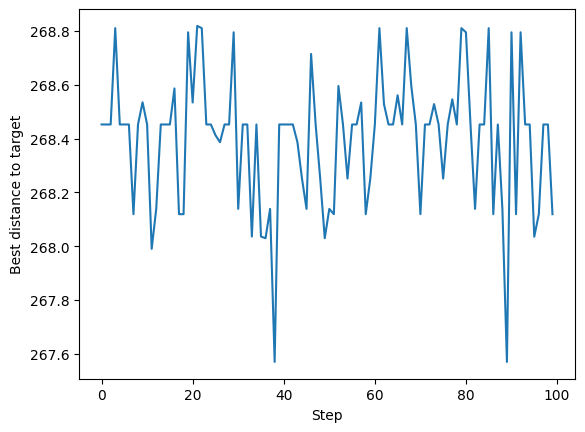

In [ ]:
x = df_summary['dis_to_target']
plt.plot(range(len(x)), x)  # x-axis: step/index, y-axis: reward
plt.xlabel("Step")
plt.ylabel("Best distance to target")
plt.show()

**Mean of distance from target opinion**


In [ ]:
# line plot
res_mean = df_summary['dis_to_target'].mean()
res_std = df_summary['dis_to_target'].std()
print('res_mean = ',res_mean)
print('res_std=', res_std)

res_mean =  268.3969486097994
res_std= 0.24648678949046346


**Opinion Distribution**

In [ ]:
all_ops = []

for item in df_full[0]:
        x_values = item[1]  # second element (list of [tensor()])
        for val in x_values:
            # each val is like [tensor(6.4090)], so extract the scalar
                tensor_val = val[0]
                if torch.is_tensor(tensor_val):
                    all_ops.append(tensor_val.item())
                else:
                    all_ops.append(float(tensor_val))


all_ops = np.array(all_ops)


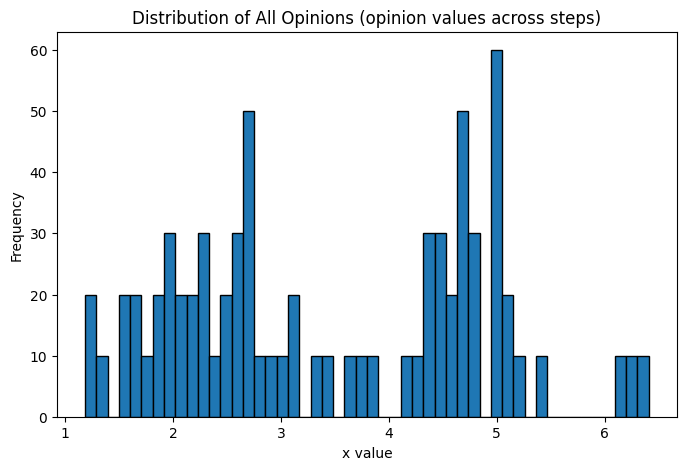

In [ ]:
# all_opinion_np, all_opinion = opinion_distribution(df_full,all_x)
plt.figure(figsize=(8,5))
plt.hist(all_x, bins=50, edgecolor='black')
plt.title("Distribution of All Opinions (opinion values across steps)")
plt.xlabel("x value")
plt.ylabel("Frequency")
plt.show()

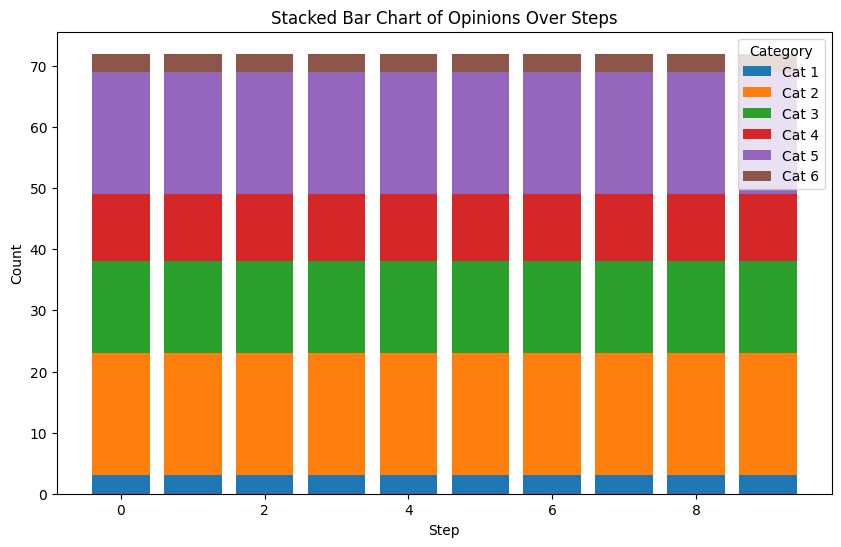

Category 1: 30.0 occurrences
Category 2: 200.0 occurrences
Category 3: 150.0 occurrences
Category 4: 110.0 occurrences
Category 5: 200.0 occurrences
Category 6: 30.0 occurrences


In [ ]:
# Plot
x_list = [item[1] for item in df_full[0]]
num_steps =len(x_list)

categories, counts = opnion_freq(x_list,num_steps)
x = np.arange(num_steps)
bottom = np.zeros(num_steps)

plt.figure(figsize=(10, 6))

for j, cat in enumerate(categories):
    plt.bar(x, counts[:, j], bottom=bottom, label=f'Cat {int(cat)}')
    bottom += counts[:, j]

plt.xlabel('Step')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Opinions Over Steps')
plt.legend(title='Category')
plt.show()

# Overall frequency of each category across all steps
total_frequency = counts.sum(axis=0)
for cat, freq in zip(categories, total_frequency):
    print(f'Category {int(cat)}: {freq} occurrences')

(720,)